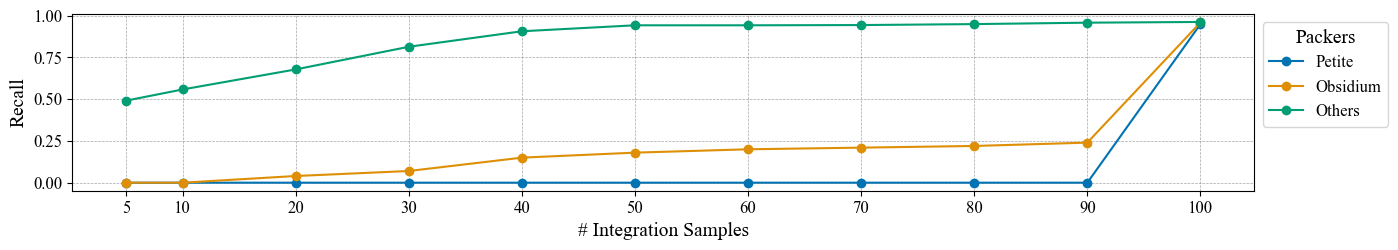

In [ ]:
# Retrieve all results.csv from the no{packer}/0 folders and merge them into a single file
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

ml_tools_dict = {}

with open('../../experiments_others/packer_integration/results/results_lcs.pickle', 'rb') as f:
    ml_tools_dict['lcs'] = pickle.load(f)

with open('../../experiments_others/packer_integration/results/results_2spiff.pickle', 'rb') as f:
    ml_tools_dict['2spiff'] = pickle.load(f)

with open('../../experiments_others/packer_integration/results/results_randomness_profiles.pickle', 'rb') as f:
    ml_tools_dict['randomness_profiles'] = pickle.load(f)

ml_tools_res = {'lcs': pd.DataFrame(), '2spiff': pd.DataFrame(), 'randomness_profiles': pd.DataFrame()}
# {'packer': {n: {'recall_new_packer': x, 'accuracy': y}, ...}} calculate the average recall for each size
for tool, res in ml_tools_dict.items():
    for packer, packer_res in res.items():
        for n, n_res in packer_res.items():
            if n != 2:
                ml_tools_res[tool].loc[(n, packer)] = n_res['recall_new_packer']

for tool, res in ml_tools_res.items():
    ml_tools_res[tool]["recall"] = res.mean(axis=1)

# drop all columns except for recall
for tool, res in ml_tools_res.items():
    ml_tools_res[tool] = ml_tools_res[tool].drop(columns=[column for column in ml_tools_res[tool].columns if column != 'recall'])

packers = ['petite', 'obsidium', 'kkrunchy', 'mpress', 'pecompact', 'pelock', 'telock', 'themida', 'upx']
df_finetuning = pd.DataFrame()
df_nofinetuning = pd.DataFrame()

# load results from res.csv in each experiment
for packer in packers:
    for i in [5] + list(range(10, 110, 10)):
        new_finetuning = pd.read_csv(f"no{packer}/{i}/res.csv")
        new_finetuning['size'] = i
        df_finetuning = pd.concat([df_finetuning, new_finetuning])
        new_nofinetuning = pd.read_csv(f"no{packer}/0/{i}/res.csv")
        new_nofinetuning['size'] = i
        df_nofinetuning = pd.concat([df_nofinetuning, new_nofinetuning])

df_finetuning = df_finetuning[df_finetuning['approach'] == 'clustering']
df_finetuning = df_finetuning.drop(columns=['approach', 'samples_num', 'avg_num_instances'])
df_finetuning = df_finetuning.set_index('packer')
df_nofinetuning = df_nofinetuning[df_nofinetuning['approach'] == 'clustering']
df_nofinetuning = df_nofinetuning.drop(columns=['approach', 'samples_num', 'avg_num_instances'])
df_nofinetuning = df_nofinetuning.set_index('packer')

# calculate the average for each size
df_finetuning = df_finetuning.groupby(['size']).mean()

# plot the trand of the average

plt.rcParams["font.family"] = "Times new Roman"

# Create a color map
color_palette = sns.color_palette("colorblind", 3)

# Plot the average trend from 10 to 100 samples
plt.figure(figsize=(14, 2.6))

# from other ml tools add results

packers[-2] = "themida-v2"

packer_map = {'upx': 'UPX', 'kkrunchy': 'kkrunchy', 'obsidium': 'Obsidium', 'pecompact':'PECompact', 'pelock': 'PELock', 'petite': 'Petite', 'themida-v2': 'Themida', 'mpress': 'MPRESS', 'telock': 'tElock'}

for packer in packers:
    if packer == 'petite' or packer == 'obsidium':
        plt.plot(df_nofinetuning.loc[packer]['size'], df_nofinetuning.loc[packer]['recall'], label=packer_map[packer], color=color_palette[packers.index(packer)], marker='o', linestyle='-', linewidth=1.5)

df_nofinetuning = df_nofinetuning.drop(index=['petite', 'obsidium'])
df_nofinetuning = df_nofinetuning.groupby(['size']).mean()
plt.plot(df_nofinetuning.index, df_nofinetuning['recall'], label='Others', color=color_palette[2], marker='o', linestyle='-', linewidth=1.5)
plt.legend(title='Packers', loc='upper left', bbox_to_anchor=(1, 1), fontsize=12, title_fontsize=14)  # Adjust legend position as needed 
plt.xlabel('# Integration Samples', fontsize=14)
plt.ylabel('Recall', fontsize=14)  # General label for all metrics
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.tick_params(labelsize=12)
plt.xticks(df_finetuning.index)

# Improve spacing between subplots (optional)
plt.tight_layout()

plt.savefig('', format='pdf')  # Uncomment to save the figure

# Show the plot
plt.show()